In [ ]:
#%%

### ch6. 投资组合优化
###########################

# 6.1 投资组合理论（最小波动率、最大夏普指数）
# 6.2 投资组合优化算法实现
# 6.3 有效边界
# 6.4 资本市场线

In [ ]:
#%%

# 导入相关的包
# pip install numpy pandas yfinance matplotlib scipy statsmodels # 安装需要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from functions_stat import print_statistics, normality_tests, gen_paths

In [ ]:
# %%

# 6.1 投资组合理论（最小波动率、最大夏普指数）
#########################################
# 投资组合优化 (Portfolio Optimization)
# 均值-方差投资组合理论（MPT）
# 正态分布收益率假设是MPT理论的基础

In [ ]:
#%%

# 6.2 投资组合优化算法实现
#########################################

# 定义股票代码列表(选前述多支股票分析例子中的四支股票)
symbols = ['600031.SH', '601138.SH', '000768.SZ', '600519.SH']
data_ = pd.read_csv("./data/stockdata-tushare-2025.csv", encoding="gbk", index_col=0, parse_dates=True)  # 从csv读取数据
data_po = data_[symbols].dropna() 
# 一定要加上dropna(), 否则如果有股票的数据缺失，后面就会报错。或者人工去观察数据，保证所有股票在相同时间范围内有数据。
print(data_po.head())
print(data_po.tail())

     600031.SH  601138.SH  000768.SZ  600519.SH
836       8.16      19.83      15.61     777.95
837       8.24      21.81      15.76     775.73
838       8.71      23.99      15.81     799.19
839       8.68      25.72      15.33     790.33
840       8.62      23.29      15.11     786.13
      600031.SH  601138.SH  000768.SZ  600519.SH
2645      20.26      60.67      24.38    1466.60
2646      20.51      55.94      25.07    1452.00
2647      20.44      56.61      24.82    1444.65
2648      20.88      58.93      24.34    1449.15
2649      20.13      60.27      24.20    1447.30


<ipython-input-4-3a112e650576>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_ = pd.read_csv("./data/stockdata-tushare-2025.csv", encoding="gbk", index_col=0, parse_dates=True)  # 从csv读取数据


In [ ]:
#%%

# 继续使用前述多支股票分析中的log_returns(对数收益率),这里重新记为rets
noa = len(symbols)
rets = np.log(data_po / data_po.shift(1))
print('\n\n年化收益率: ')
print(rets.mean()*252)  #年化收益率。每年252个交易日
print('\n协方差矩阵: ')
print(rets.cov()*252)  #协方差矩阵，是投资组合选择过程的核心部分。

print('\n\n某组随机权重的预期收益和预期波动率: ')
weights = np.random.random(noa)
weights /= np.sum(weights)  #保证权重的总和为1
print('\n权重: ')
print(weights)
print('\n预期收益: ')
print(np.sum(rets.mean() * weights) * 252)  #预期收益
print('\n预期投资组合方差: ')
print(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))  #预期投资组合方差
print('\n预期波动率(投资组合标准差): ')
print(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))  #预期波动率（投资组合标准差）



年化收益率: 
600031.SH    0.125509
601138.SH    0.154513
000768.SZ    0.060942
600519.SH    0.086288
dtype: float64

协方差矩阵: 
           600031.SH  601138.SH  000768.SZ  600519.SH
600031.SH   0.128536   0.046667   0.044772   0.042488
601138.SH   0.046667   0.220891   0.048647   0.034578
000768.SZ   0.044772   0.048647   0.148262   0.025198
600519.SH   0.042488   0.034578   0.025198   0.085844


某组随机权重的预期收益和预期波动率: 

权重: 
[0.31246859 0.01653336 0.44882393 0.22217411]

预期收益: 
0.08829518794762006

预期投资组合方差: 
0.07165472201078453

预期波动率(投资组合标准差): 
0.2676839965533699




随机模拟2500次的预期收益和预期波动率: 


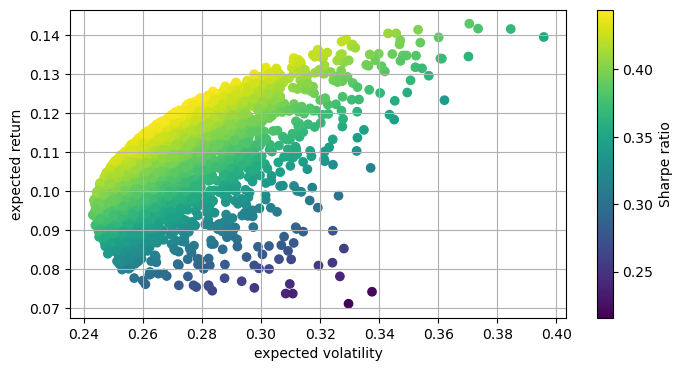

In [ ]:
# %%

###蒙特卡洛模拟。预期的投资组合收益和方差
print('\n\n随机模拟2500次的预期收益和预期波动率: ')
prets = [] # 预期收益
pvols = [] # 预期波动率
for p in range (2500):
    weights = np.random.random(noa) # 随机权重
    weights /= np.sum(weights)      # 权重总和为1
    prets.append(np.sum(rets.mean() * weights) * 252)  # 预期收益
    pvols.append(np.sqrt(np.dot(weights.T, 
                                np.dot(rets.cov() * 252, weights)
                                )))  # 预期波动率
prets = np.array(prets)
pvols = np.array(pvols)

# 下图显示了2500个随机投资组合的预期收益和预期波动率
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [ ]:
#%%

# 计算最小波动率和最大夏普指数条件下的最优投资组合

#定义函数，根据权重计算收益和波动率
def statistics(weights):
    weights = np.array(weights) # 权重
    pret = np.sum(rets.mean() * weights) * 252  # 预期收益
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))  # 预期波动率
    return np.array([pret, pvol, pret / pvol])

import scipy.optimize as sco

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  # 约束条件：权重总和为1
bnds = tuple((0, 1) for x in range(noa))  # 权重的取值范围
noa * [1. / noa,]  # 初始权重

# 最大化夏普指数（最小化夏普指数的负值）
def min_func_sharpe(weights):
    return -statistics(weights)[2]

# opts 为最大夏普指数情况下的最优投资组合
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons) # SLSQP是一种优化算法,Sequential Least SQuares Programming, 顺序最小二乘法
print('\n\n最大夏普指数情况下: ')
print(opts)
print('\n最优投资组合为: ')
print(symbols)
print(opts['x'].round(3))
print('\n最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为: ')
print(statistics(opts['x']).round(3))

# 最小化投资组合的方差，即最小化波动率
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

# optv 为最小波动率情况下的最优投资组合
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons) 
print('\n\n最小波动率情况下: ')
print(optv)
print('\n最优投资组合为: ')
print(optv['x'].round(3))
print('\n最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为: ')
print(statistics(optv['x']).round(3))



最大夏普指数情况下: 
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.44477200852113313
       x: [ 3.932e-01  3.011e-01  0.000e+00  3.057e-01]
     nit: 5
     jac: [ 1.170e-04 -3.778e-04  1.351e-02  2.216e-04]
    nfev: 25
    njev: 5

最优投资组合为: 
['600031.SH', '601138.SH', '000768.SZ', '600519.SH']
[0.393 0.301 0.    0.306]

最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为: 
[0.122 0.275 0.445]


最小波动率情况下: 
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.05901401955356799
       x: [ 1.813e-01  1.036e-01  2.253e-01  4.897e-01]
     nit: 8
     jac: [ 1.181e-01  1.185e-01  1.178e-01  1.180e-01]
    nfev: 40
    njev: 8

最优投资组合为: 
[0.181 0.104 0.225 0.49 ]

最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为: 
[0.095 0.243 0.39 ]



有效边界，左侧*表示给定收益率水平的最小方差/波动率的投资组合，另一个*表示最大夏普指数的投资组合。


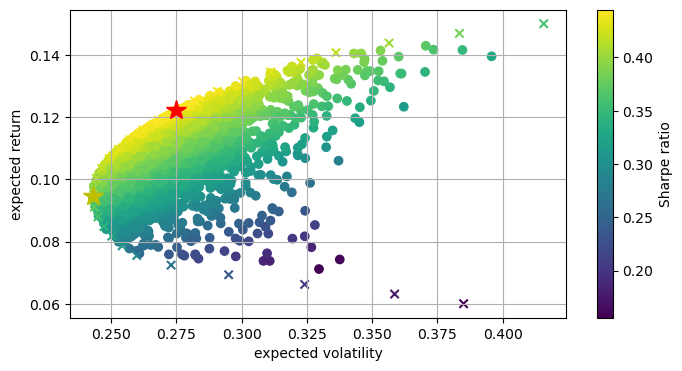

In [ ]:
# %%

# 6.3 有效边界（Efficient Frontier）
##################################

#目标收益水平下波动率最小的投资组合
#给定波动率水平下收益最大的投资组合
# constraints: 两个约束条件，一个是给定目标收益率，另一个是权重总和为1
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},{'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights) # 权重的取值范围

def min_func_port(weights):
    return statistics(weights)[1]

# 给定目标收益率水平下的最小波动率投资组合
# 注意，如果后面画资本市场线时报数据错误，下面这三个参数需要修改，
# 默认是(0, 0.25, 50), 可以观察前后有没有垂直出现的x来调整取值。
trets = np.linspace(0.06, 0.15, 30) # 目标收益率水平
tvols = [] # 目标收益率水平下的最小波动率
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # 约束条件
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                    bounds=bnds, constraints=cons) # 最小化波动率
    tvols.append(res['fun']) # 最小波动率
tvols = np.array(tvols) # 目标收益率水平下的最小波动率

print('\n有效边界，左侧*表示给定收益率水平的最小方差/波动率的投资组合，另一个*表示最大夏普指数的投资组合。')
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
        'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
        'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

<ipython-input-9-d1548982c390>:26: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  opt = sco.fsolve(equations, [0.01, 0.6, 0.10]) # 无风险利率、资本市场线的斜率和截距，比如rf=0.01, p=(0.01, 0.5, 0.15)



资本市场线。
数值优化结果
[0.02       0.40311628 0.24425089]

方程是否合乎预期（值是否为零）
[ 0.        0.018174 -0.004439]

下图星号代表有效边界中切线穿过无风险资产点。即无风险利率为1%时的资本市场线和相切的投资组合。


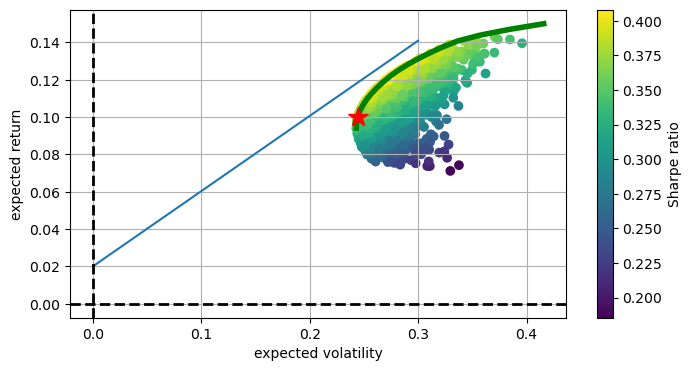


最优投资组合的权重
[0.224 0.142 0.178 0.455]

最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为：
[0.1   0.244 0.41 ]


In [ ]:
# %%

# 6.4 资本市场线（Capital Market Line）
#####################################

import scipy.interpolate as sci

ind = np.argmin(tvols) # 最小波动率的索引
evols = tvols[ind:] # 有效边界的波动率
erets = trets[ind:] # 有效边界的收益率

tck = sci.splrep(evols, erets) # 样条插值,返回一个三元组(t,c,k),其中t是节点，c是系数，k是阶数

def f(x):
    ''' Efficient frontier function (splines approximation). 有效边界函数（样条逼近） '''
    return sci.splev(x, tck, der=0) # 样条插值；der=0表示零阶导数
def df(x):
    ''' First derivative of efficient frontier function. 有效边界函数的一阶导数 '''
    return sci.splev(x, tck, der=1) # 样条插值；der=1表示一阶导数

def equations(p, rf=0.02):
    eq1 = rf - p[0] # 无风险利率
    eq2 = rf + p[1] * p[2] - f(p[2]) # 资本市场线
    eq3 = p[1] - df(p[2]) # 资本市场线的斜率
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.6, 0.10]) # 无风险利率、资本市场线的斜率和截距，比如rf=0.01, p=(0.01, 0.5, 0.15)
#上述参数（包括equations函数）需要反复尝试，组合各种合理的猜测。

print('\n资本市场线。\n数值优化结果')
print(opt)
print('\n方程是否合乎预期（值是否为零）')
print(np.round(equations(opt), 6))
print('\n下图星号代表有效边界中切线穿过无风险资产点。即无风险利率为1%时的资本市场线和相切的投资组合。')
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o')
            # random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3) # 有效边界的波动率范围
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# constraints: 两个约束条件，一个是给定目标收益率，另一个是权重总和为1
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # 约束条件
# sco.minimize函数
# min_func_port是目标函数，即波动率, noa * [1. / noa,]是初始权重, method='SLSQP'是优化算法, bounds=bnds是权重的取值范围, constraints=cons是约束条件
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)
print('\n最优投资组合的权重')
print(res['x'].round(3))
print('\n最优投资组合情况下的预期收益率、波动率和最优夏普指数分别为：')
print(statistics(res['x']).round(3))

In [ ]:
# %%

############################END#############################